### Import librairies

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.library import IntegerComparator
from qiskit.visualization import plot_histogram
import itertools
import numpy as np
import math
import random

### Define the problem

In [2]:
# Dataset
PG_i = [int(random.random()*16) for _ in range(2**3)]

# Initialize the treshold
theta_index = random.randint(0,len(PG_i)-1) 
theta =  PG_i[theta_index]

# Initialize the number of qubits
nb_qram = math.ceil(math.log2(len(PG_i)))
nb_val = math.ceil(math.log2(16))
nb_ancilla = nb_val-1
nb_comparator = nb_val + nb_ancilla + 1

# Create the Quantum Registers
qram = QuantumRegister(nb_qram, 'qram')
qval = QuantumRegister(nb_val, 'qval')
comp_output = QuantumRegister(1, 'comp_output')
ancilla = QuantumRegister(nb_ancilla, 'ancilla')
oracle = QuantumRegister(1, 'oracle')
cr = ClassicalRegister(nb_qram, 'classical')

# Create the Quantum Circuit 
qc = QuantumCircuit(qram, qval, comp_output, ancilla, oracle, cr)

### Define the Quantum RAM

In [3]:
def QRAM(nb_qram, nb_val, data):
    map_ram = list(itertools.product([0, 1], repeat=nb_qram))
    qram = QuantumRegister(nb_qram, 'qram')
    qval = QuantumRegister(nb_val, 'qval')
    qc = QuantumCircuit(qram, qval, name='QRAM')
        
    # Map data of the dataset
    for d, m_ram in zip(data, map_ram):

        # Init mapping
        for index, gate in enumerate(m_ram):
            if gate == 0:
                qc.x(qram[index])
             
        # Encode the value in QRAM
        binary_str = bin(d)[2:].zfill(nb_val)

        for i, bit in enumerate(binary_str):
            if bit == '1':
                qc.mcx(qram, qval[i])
        
        # Close mapping
        for index, gate in enumerate(m_ram):
            if gate == 0:
                qc.x(qram[index])
                
        qc.barrier()

    return qc

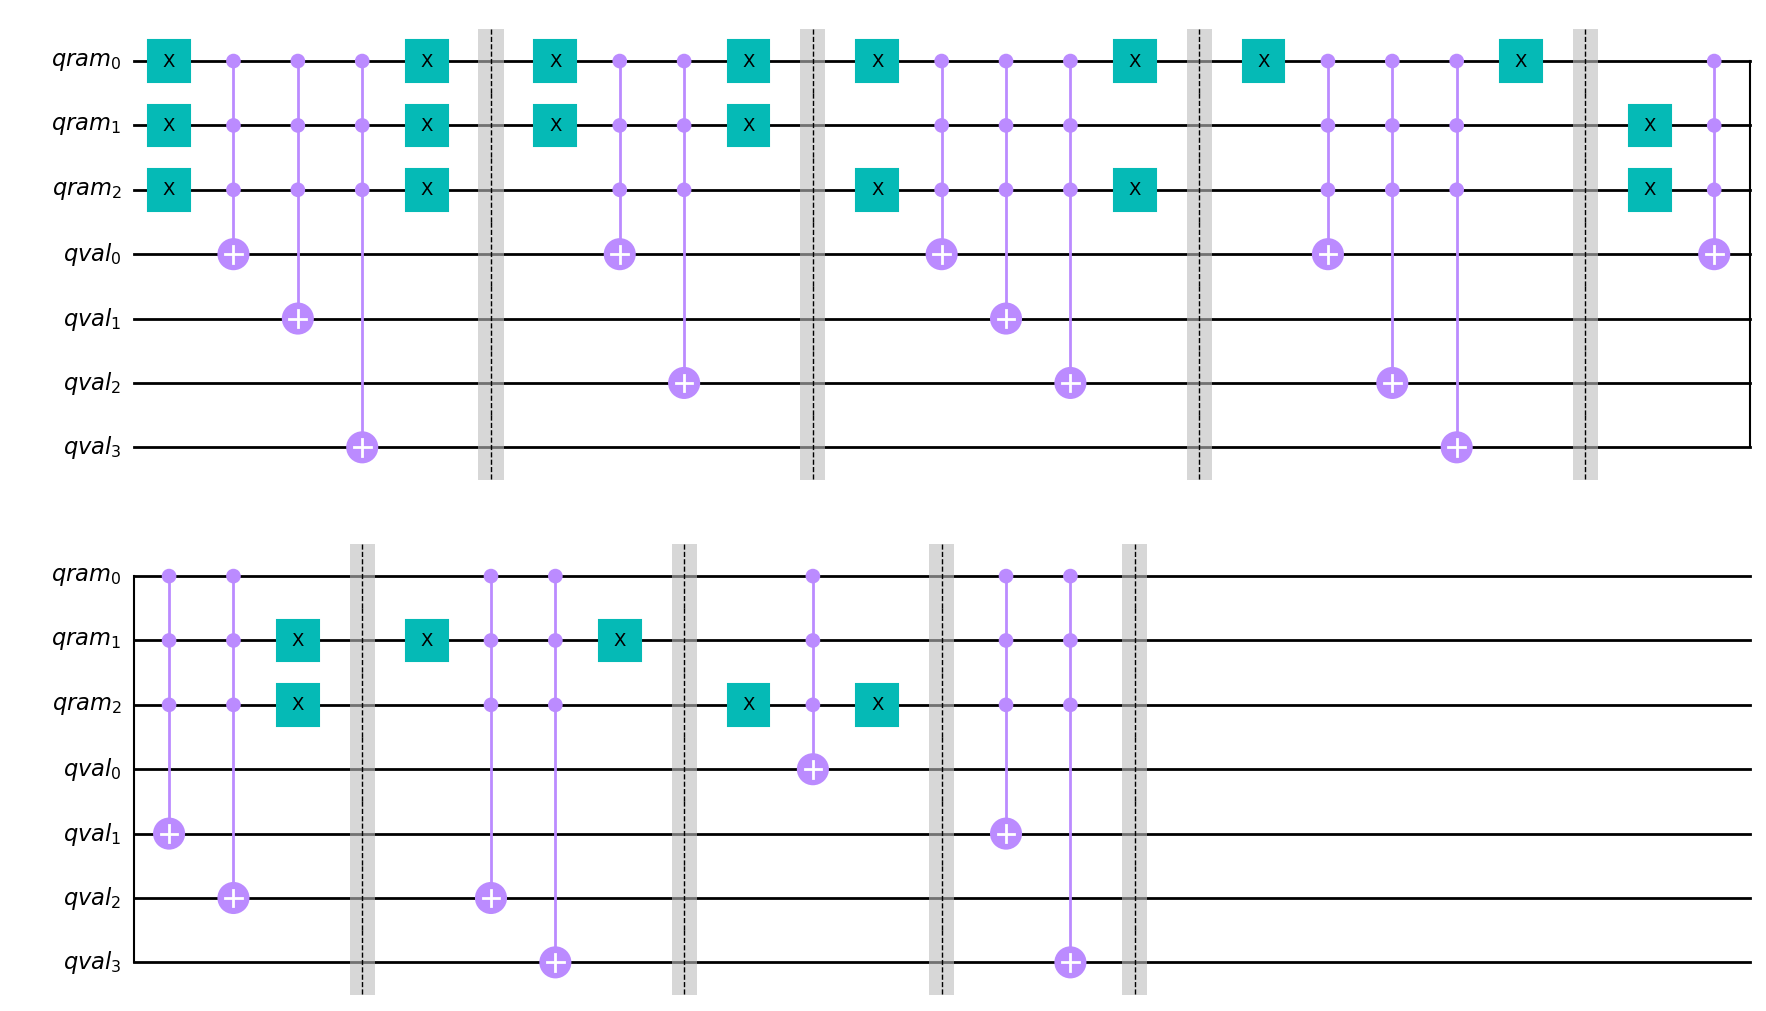

In [4]:
QRAM(nb_qram, nb_val, PG_i).draw(output="mpl")

### Define the Diffuser

In [5]:
def diffuser(nqubits):
    
    qc = QuantumCircuit(nqubits, name='Diffuser')
    
    for qubit in range(nqubits):
        qc.h(qubit)
        qc.x(qubit)
        
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    
    for qubit in range(nqubits):
        qc.h(qubit)
        qc.x(qubit)

    return qc

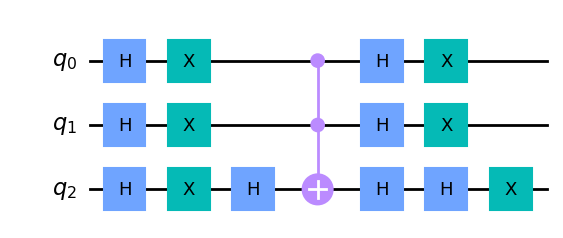

In [6]:
diffuser(nb_qram).draw(output='mpl')

### Define the comparator

In [7]:
def comparator(nb_comparator, nb_val, theta):
    
    return IntegerComparator(num_state_qubits=nb_val, value=theta, geq=True, name='Comparator')

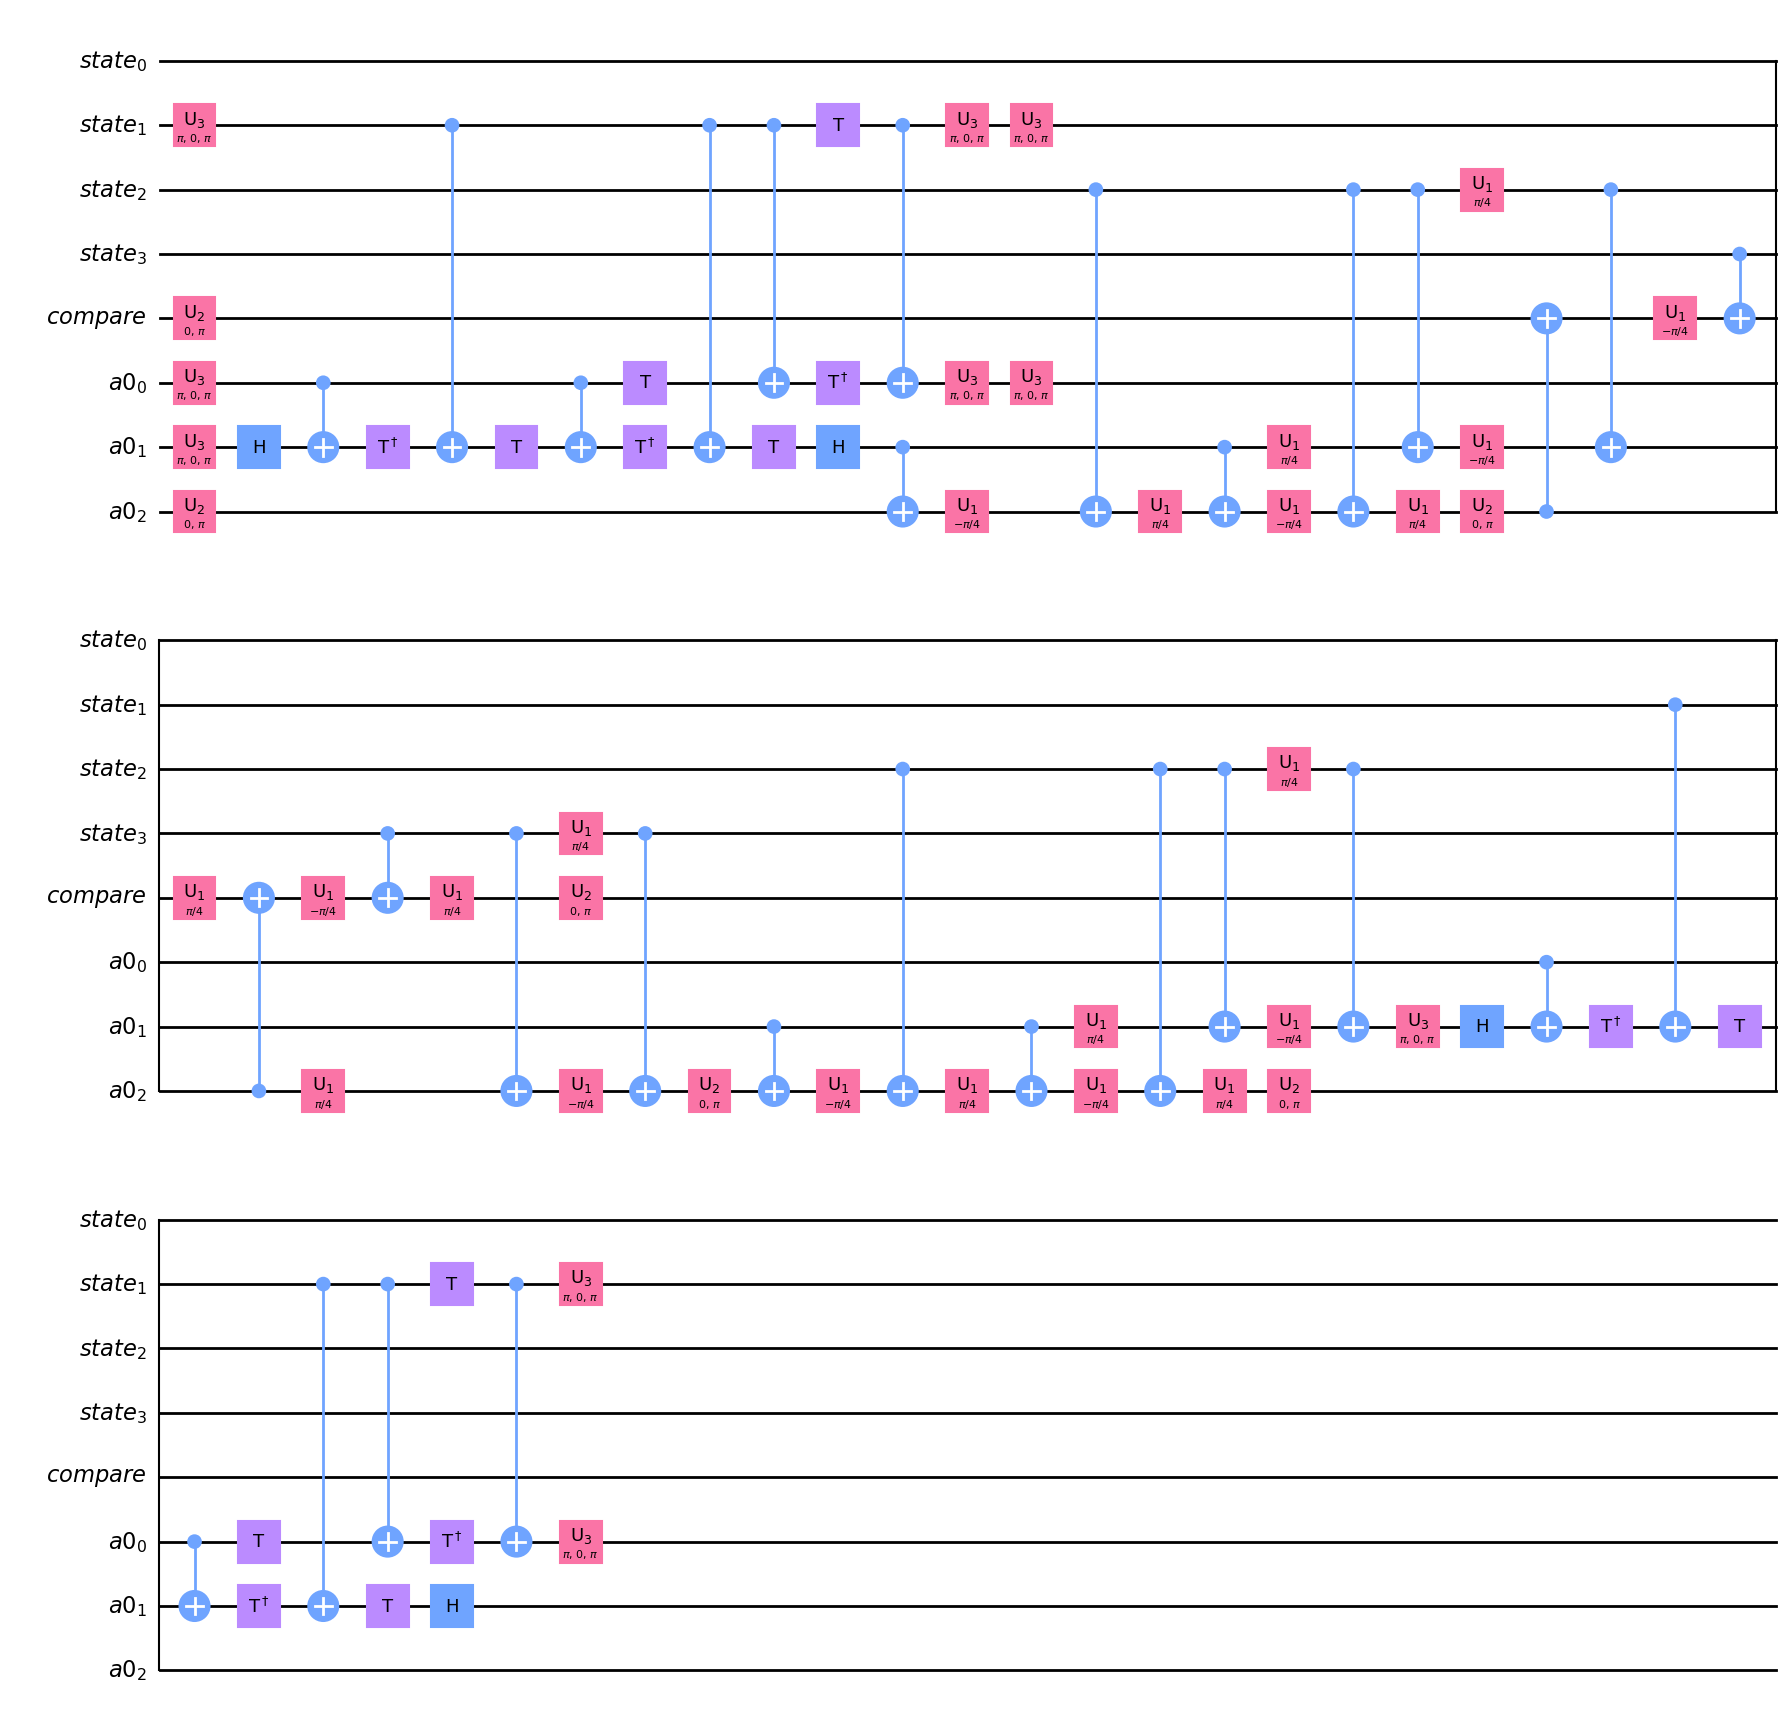

In [8]:
comparator(nb_comparator, nb_val, theta).decompose().decompose().decompose().draw(output='mpl')

### Create the oracle : QRAM+COMP + CX + QRAM.dg+COMP.dg

In [9]:
def Oracle(theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator):
    
    # Create the Quantum Registers
    qram = QuantumRegister(nb_qram, 'qram')
    qval = QuantumRegister(nb_val, 'qval')
    comp_output = QuantumRegister(1, 'comp_output')
    ancilla = QuantumRegister(nb_ancilla, 'ancilla')
    oracle = QuantumRegister(1, 'oracle')

    # Create the Quantum Circuit 
    qc = QuantumCircuit(qram, qval, comp_output, ancilla, oracle, name='Oracle')
    
    # Initialisation of the oracle
    qc.x(oracle)
    qc.h(oracle)
    
    # Entanglement between Oracle and QRAM
    qc.mcx(qram, oracle)
    
    # QRAM
    qc.append(QRAM(nb_qram, nb_val, PG_i), [*[i for i in range(nb_qram + nb_val)]]) # O(N²)
    qc.barrier()

    # Comparator
    qc.append(comparator(nb_comparator, nb_val, theta),[*[i for i in range(nb_qram, nb_qram + nb_comparator)]] )
    qc.barrier()
    
    # Oracle
    qc.cx(comp_output, oracle)
    qc.barrier()

    # Revert comparator
    qc.append(comparator(nb_comparator, nb_val, theta).inverse(),[*[i for i in range(nb_qram, nb_qram + nb_comparator)]] )
    qc.barrier()
    
    # Revert QRAM
    qc.append(QRAM(nb_qram, nb_val, PG_i).inverse(), [*[i for i in range(nb_qram + nb_val)]])
    qc.barrier()
    
    return qc

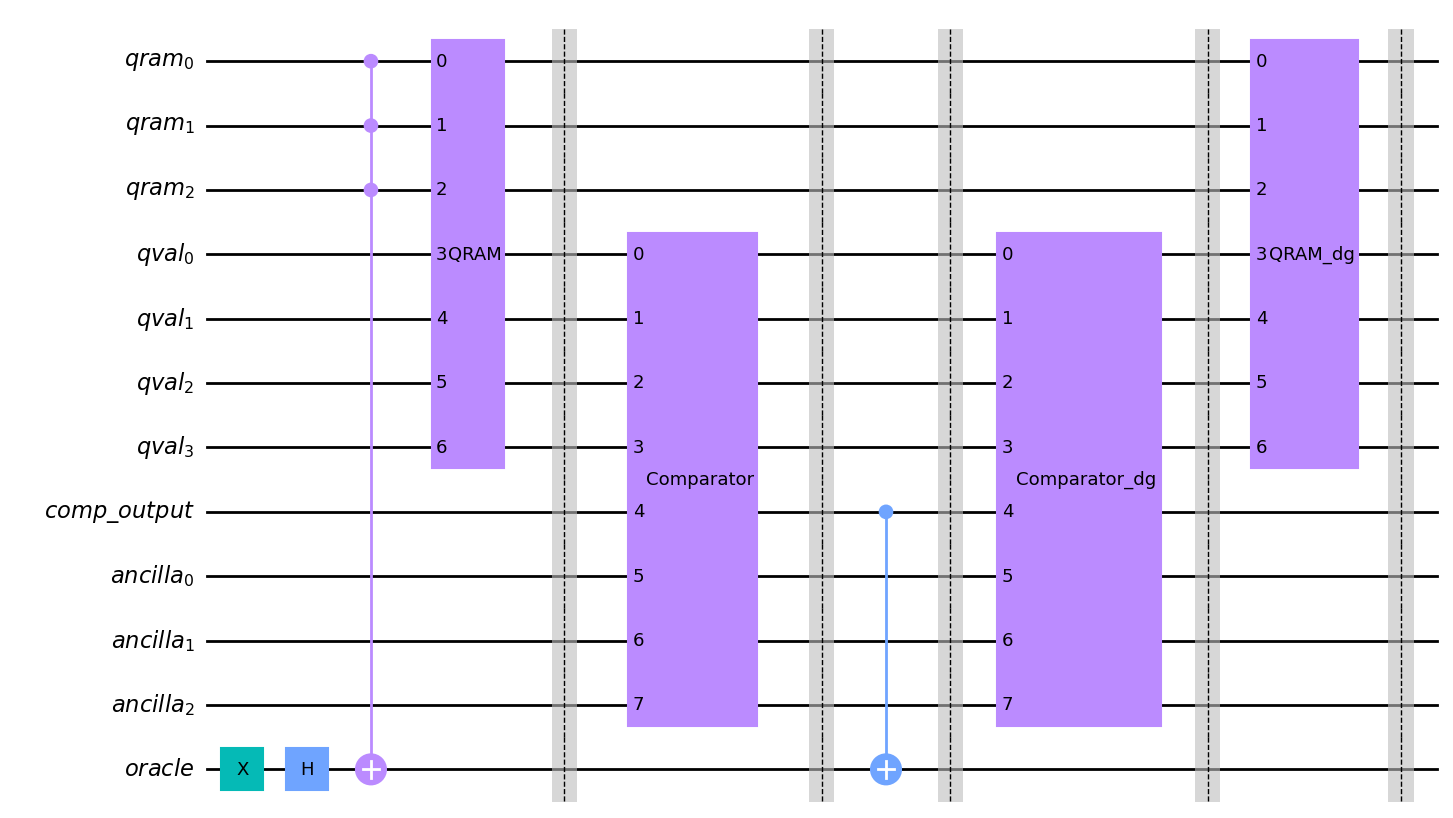

In [10]:
Oracle(theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator).draw(output="mpl")

### Create the grover operator

In [11]:
def grover_operator(theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator):
    
    # Create the Quantum Registers
    qram = QuantumRegister(nb_qram, 'qram')
    qval = QuantumRegister(nb_val, 'qval')
    comp_output = QuantumRegister(1, 'comp_output')
    ancilla = QuantumRegister(nb_ancilla, 'ancilla')
    oracle = QuantumRegister(1, 'oracle')
    
    # Create the Quantum Circuit 
    qc = QuantumCircuit(qram, qval, comp_output, ancilla, oracle, name='Grov_Op')
    
    # Oracle
    qc.append(Oracle(theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator), [*[i for i in range(nb_qram + nb_comparator + 1)]])
    
    # Diffuser
    qc.append(diffuser(nb_qram), [*[i for i in range(nb_qram)]])
    qc.barrier()
    
    return qc

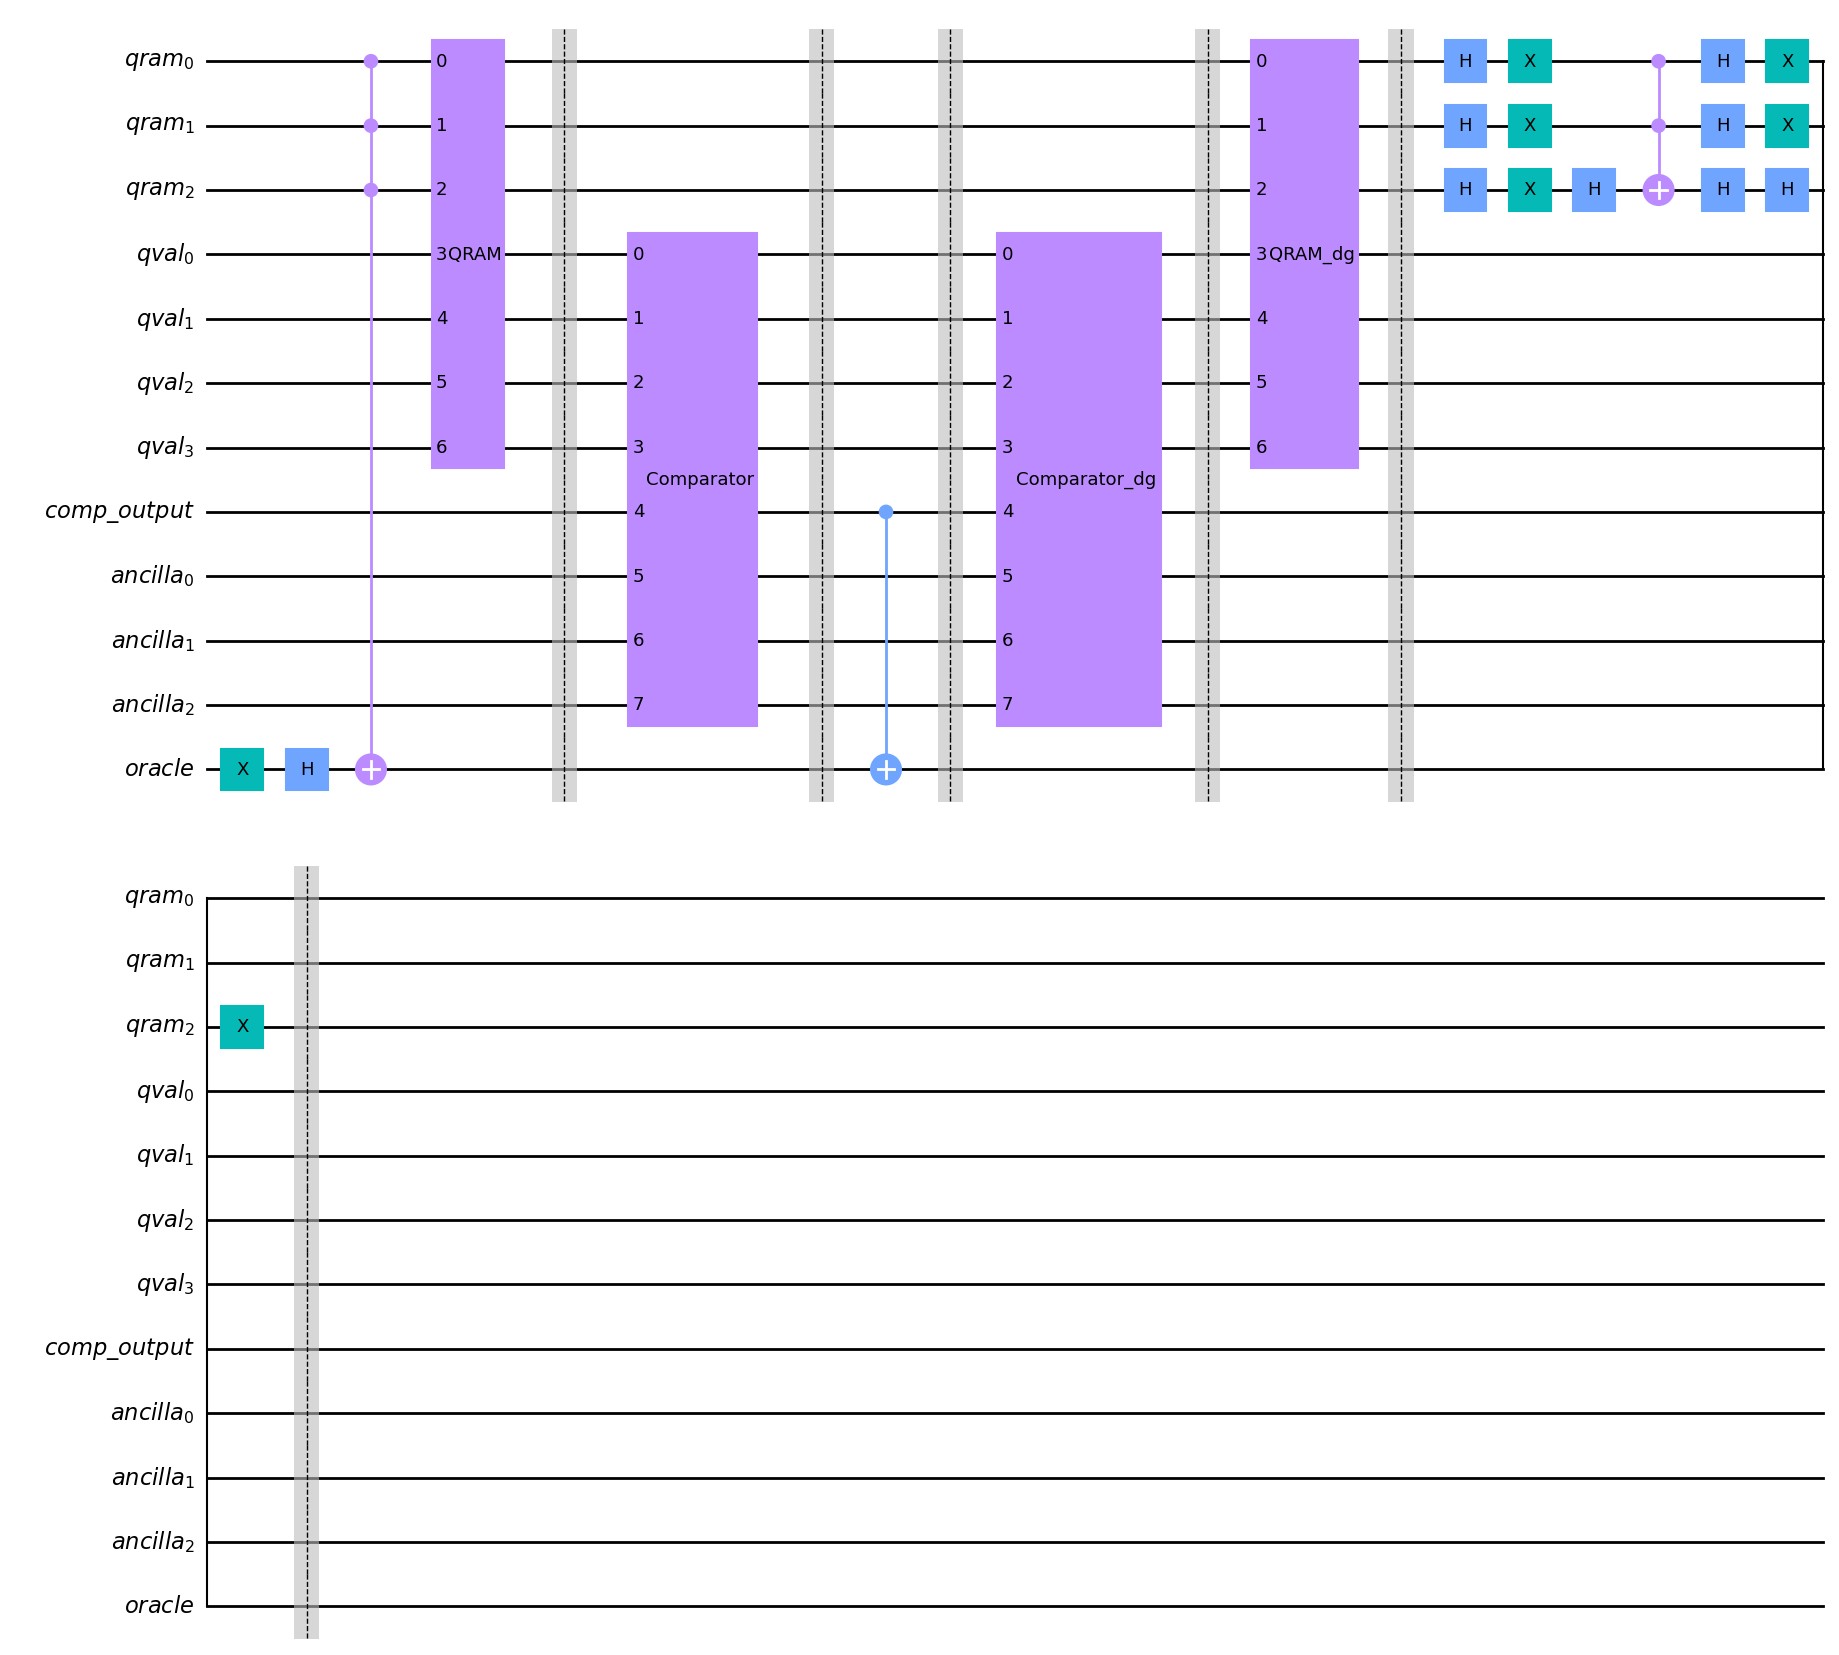

In [12]:
grover_operator(theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator).decompose().draw(output='mpl')

### Create the circuit with good number of iteration of the grover operator and measurement

In [13]:
def grover_iteration(num_iterations, theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator):
    
    # Create the Quantum Registers
    qram = QuantumRegister(nb_qram, 'qram')
    qval = QuantumRegister(nb_val, 'qval')
    comp_output = QuantumRegister(1, 'comp_output')
    ancilla = QuantumRegister(nb_ancilla, 'ancilla')
    oracle = QuantumRegister(1, 'oracle')
    cr = ClassicalRegister(nb_qram, 'classical')

    # Create the Quantum Circuit 
    qc = QuantumCircuit(qram, qval, comp_output, ancilla, oracle, cr)
    
    # Apply num_iteration times the Grover Operator
    for _ in range(0, num_iterations):
        qc.append(grover_operator(theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator), [*[i for i in range(nb_qram + nb_comparator + 1)]])
    
    # Measure
    qc.measure(qram, cr)
    
    # Get the new theta index
    qc = qc.reverse_bits()
    backend = Aer.get_backend("qasm_simulator")
    job = execute(qc, backend, shots=1)
    count = job.result().get_counts()
    
    new_theta_index = int(list(count.keys())[0], 2)

    return new_theta_index

### Quantum Exponential Search Algorithm (QESA)

In [14]:
def QESA(theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator):

    m = 1
    alpha = 6/5 
    
    while True:
        num_iterations = random.randint(1, int(m)) 
        new_theta_index = grover_iteration(num_iterations, theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator)
       
        if PG_i[new_theta_index] < theta:
            m = min(alpha*m, math.sqrt(len(PG_i)))
        else:
            break
    
    return new_theta_index

### Quantum Maximum Search Algorithm (QMSA)

In [15]:
# Set the number of iterations of QESA
max_iteration = int(math.sqrt(len(PG_i)))
print('max_iteration:',max_iteration)

for _ in range(0, max_iteration):
    new_theta_index = QESA(theta, PG_i, nb_qram, nb_val, nb_ancilla, nb_comparator)
    print("new_theta_index:",new_theta_index)

max_iteration: 2
new_theta_index: 2
new_theta_index: 4


### Results

In [16]:
print('PG_i : ', PG_i) 
print('QUANTUM max :',PG_i[new_theta_index])
PG_i.sort()
classi_best_suggestion = PG_i[-1]
print('CLASSICAL max :',classi_best_suggestion)

PG_i :  [13, 10, 14, 11, 14, 3, 8, 5]
QUANTUM max : 14
CLASSICAL max : 14
